In [43]:
import pandas as pd
import numpy as np

# Function to generate items
def create_items_dataframe_integer(num_items, value_min, value_max, cost_min, cost_max):
    """
    Create a pandas DataFrame with N items, each having a randomly sampled integer value and cost.
    
    Parameters:
    - num_items (int): Number of items to generate.
    - value_min (int): Minimum possible value for the 'value' column.
    - value_max (int): Maximum possible value for the 'value' column.
    - cost_min (int): Minimum possible cost for the 'cost' column.
    - cost_max (int): Maximum possible cost for the 'cost' column.
    
    Returns:
    - DataFrame: A pandas DataFrame with columns ['item', 'value', 'cost'].
    """
    data = {
        'item': [f'Item_{i+1}' for i in range(num_items)],
        'value': np.random.randint(value_min, value_max + 1, num_items),
        'cost': np.random.randint(cost_min, cost_max + 1, num_items),
    }
    return pd.DataFrame(data)

# Example data
items_df = create_items_dataframe_integer(num_items=10, value_min=10, value_max=100, cost_min=1, cost_max=20)
items_df


,item,value,cost
0,Item_1,10,8
1,Item_2,85,8
2,Item_3,62,17
3,Item_4,90,11
4,Item_5,75,18
5,Item_6,79,6
6,Item_7,78,19
7,Item_8,27,17
8,Item_9,88,8
9,Item_10,55,20


In [44]:
capacity = 50


In [53]:
from ortools.linear_solver import pywraplp

def knapsack_optimization_pywraplp(items_df, capacity):
    """
    Solve the 0/1 Knapsack Problem using OR-Tools' pywraplp solver with integer constraints.

    Parameters:
    - items_df (DataFrame): A pandas DataFrame containing columns 'item', 'value', and 'cost'.
    - capacity (int): The maximum weight capacity of the knapsack.

    Returns:
    - Tuple:
        - max_value (int): The maximum value achievable within the given capacity.
        - selected_items (list): The list of selected items.
    """
    # Initialize the solver
    solver = pywraplp.Solver.CreateSolver("SCIP")
    if not solver:
        return None, None

    num_items = len(items_df)
    values = items_df['value'].tolist()
    costs = items_df['cost'].tolist()

    # Decision variables: x[i] = 1 if item i is included, 0 otherwise
    x = [solver.IntVar(0, 1, f'x[{i}]') for i in range(num_items)]

    # Objective function: maximize total value
    solver.Maximize(solver.Sum(values[i] * x[i] for i in range(num_items)))

    # Constraint: total cost cannot exceed capacity
    solver.Add(solver.Sum(costs[i] * x[i] for i in range(num_items)) <= capacity)

    # Solve the problem
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        max_value = solver.Objective().Value()
        selected_items = [items_df.iloc[i]['item'] for i in range(num_items) if x[i].solution_value() > 0]
        return max_value, selected_items
    else:
        return None, None


# Solve using pywraplp
max_value_pywraplp, selected_items_pywraplp = knapsack_optimization_pywraplp(items_df, capacity)
max_value_pywraplp, selected_items_pywraplp


(357.0, ['Item_1', 'Item_4', 'Item_5', 'Item_7', 'Item_10'])

In [52]:
import random

def knapsack_ga_local_search(items_df, capacity, population_size=50, generations=500, mutation_rate=0.5):
    """
    Solve the knapsack problem using a Genetic Algorithm (GA) with local search.

    Parameters:
    - items_df (DataFrame): A pandas DataFrame containing columns 'item', 'value', and 'cost'.
    - capacity (int): The maximum weight capacity of the knapsack.
    - population_size (int): Number of individuals in the population.
    - generations (int): Number of generations for the GA.
    - mutation_rate (float): Probability of mutating a gene.

    Returns:
    - Tuple:
        - best_value (int): The maximum value achieved.
        - best_solution (list): List of selected items in the best solution.
    """
    num_items = len(items_df)
    values = items_df['value'].tolist()
    costs = items_df['cost'].tolist()

    # Fitness function: total value if feasible, otherwise 0
    def fitness(solution):
        total_value = sum(v * s for v, s in zip(values, solution))
        total_cost = sum(c * s for c, s in zip(costs, solution))
        return total_value if total_cost <= capacity else 0

    # Local search: try flipping bits to improve fitness
    def local_search(solution):
        best_solution = solution[:]
        best_fitness = fitness(best_solution)
        for i in range(num_items):
            neighbor = best_solution[:]
            neighbor[i] = 1 - neighbor[i]  # Flip bit
            if fitness(neighbor) > best_fitness:
                best_solution = neighbor
                best_fitness = fitness(neighbor)
        return best_solution

    # Generate initial population
    population = [[random.randint(0, 1) for _ in range(num_items)] for _ in range(population_size)]

    for generation in range(generations):
        # Evaluate fitness of population
        fitness_values = [fitness(individual) for individual in population]

        # Select parents (roulette wheel selection)
        total_fitness = sum(fitness_values)
        probabilities = [f / total_fitness for f in fitness_values]
        parents = random.choices(population, probabilities, k=population_size)

        # Crossover (single-point)
        next_generation = []
        for _ in range(population_size // 2):
            parent1, parent2 = random.sample(parents, 2)
            crossover_point = random.randint(1, num_items - 1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            next_generation.extend([child1, child2])

        # Mutation
        for individual in next_generation:
            if random.random() < mutation_rate:
                mutation_point = random.randint(0, num_items - 1)
                individual[mutation_point] = 1 - individual[mutation_point]  # Flip bit

        # Apply local search to each individual
        population = [local_search(individual) for individual in next_generation]

    # Get the best solution
    best_solution = max(population, key=fitness)
    best_value = fitness(best_solution)
    selected_items = [items_df.iloc[i]['item'] for i in range(num_items) if best_solution[i] == 1]

    return best_value, selected_items


# Solve using GA with local search
best_value_ga_ls, selected_items_ga_ls = knapsack_ga_local_search(items_df, capacity)
best_value_ga_ls, selected_items_ga_ls


(357, ['Item_1', 'Item_4', 'Item_5', 'Item_7', 'Item_10'])

In [51]:
def knapsack_ga_local_search_formatted_v2(items_df, capacity, population_size=50, generations=500, mutation_rate=0.5):
    """
    Solve the knapsack problem using a Genetic Algorithm (GA) with local search, formatted as required.

    Parameters:
    - items_df (DataFrame): A pandas DataFrame containing columns 'item', 'value', and 'cost'.
    - capacity (int): The maximum weight capacity of the knapsack.
    - population_size (int): Number of individuals in the population.
    - generations (int): Number of generations for the GA.
    - mutation_rate (float): Probability of mutating a gene.

    Returns:
    - Tuple:
        - selected_indices (list): Indices of selected items in the best solution.
        - best_value (int): The maximum value achieved.
    """
    num_items = len(items_df)
    values = items_df['value'].tolist()
    costs = items_df['cost'].tolist()

    # Fitness function: total value if feasible, otherwise 0
    def fitness(solution):
        total_value = sum(v * s for v, s in zip(values, solution))
        total_cost = sum(c * s for c, s in zip(costs, solution))
        return total_value if total_cost <= capacity else 0

    # Local search: try flipping bits to improve fitness
    def local_search(solution):
        best_solution = solution[:]
        best_fitness = fitness(best_solution)
        for i in range(num_items):
            neighbor = best_solution[:]
            neighbor[i] = 1 - neighbor[i]  # Flip bit
            if fitness(neighbor) > best_fitness:
                best_solution = neighbor
                best_fitness = fitness(neighbor)
        return best_solution

    # Generate initial population
    population = [[random.randint(0, 1) for _ in range(num_items)] for _ in range(population_size)]

    for generation in range(generations):
        # Evaluate fitness of population
        fitness_values = [fitness(individual) for individual in population]

        # Select parents (roulette wheel selection)
        total_fitness = sum(fitness_values)
        probabilities = [f / total_fitness for f in fitness_values]
        parents = random.choices(population, probabilities, k=population_size)

        # Crossover (single-point)
        next_generation = []
        for _ in range(population_size // 2):
            parent1, parent2 = random.sample(parents, 2)
            crossover_point = random.randint(1, num_items - 1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            next_generation.extend([child1, child2])

        # Mutation
        for individual in next_generation:
            if random.random() < mutation_rate:
                mutation_point = random.randint(0, num_items - 1)
                individual[mutation_point] = 1 - individual[mutation_point]  # Flip bit

        # Apply local search to each individual
        population = [local_search(individual) for individual in next_generation]

    # Get the best solution
    best_solution = max(population, key=fitness)
    best_value = fitness(best_solution)

    # Extract the indices of the selected items
    selected_indices = [i for i in range(num_items) if best_solution[i] == 1]

    return selected_indices, best_value


# Test the function with a sample dataset
items_df = create_items_dataframe_integer(10, 10, 100, 1, 20)
capacity = 50
selected_indices, best_value = knapsack_ga_local_search_formatted_v2(items_df, capacity)

selected_indices, best_value


([0, 3, 4, 6, 9], 357)

In [54]:
def knapsack_ga_local_search_improved(
    items_df, capacity, population_size=50, generations=200, mutation_rate=0.2, elitism_count=2
):
    """
    Improved Genetic Algorithm (GA) with local search for the knapsack problem.

    Parameters:
    - items_df (DataFrame): A pandas DataFrame containing columns 'item', 'value', and 'cost'.
    - capacity (int): The maximum weight capacity of the knapsack.
    - population_size (int): Number of individuals in the population.
    - generations (int): Number of generations for the GA.
    - mutation_rate (float): Probability of mutating a gene.
    - elitism_count (int): Number of best individuals to carry over directly to the next generation.

    Returns:
    - Tuple:
        - best_value (int): The maximum value achieved.
        - best_solution (list): List of selected items in the best solution.
    """
    num_items = len(items_df)
    values = items_df['value'].tolist()
    costs = items_df['cost'].tolist()

    # Fitness function: total value if feasible, otherwise 0
    def fitness(solution):
        total_value = sum(v * s for v, s in zip(values, solution))
        total_cost = sum(c * s for c, s in zip(costs, solution))
        return total_value if total_cost <= capacity else 0

    # Local search: try flipping bits to improve fitness
    def local_search(solution):
        best_solution = solution[:]
        best_fitness = fitness(best_solution)
        for i in range(num_items):
            neighbor = best_solution[:]
            neighbor[i] = 1 - neighbor[i]  # Flip bit
            if fitness(neighbor) > best_fitness:
                best_solution = neighbor
                best_fitness = fitness(neighbor)
        return best_solution

    # Generate initial population
    population = [[random.randint(0, 1) for _ in range(num_items)] for _ in range(population_size)]

    for generation in range(generations):
        # Evaluate fitness of population
        fitness_values = [fitness(individual) for individual in population]

        # Elitism: Retain the top solutions
        sorted_population = [x for _, x in sorted(zip(fitness_values, population), reverse=True)]
        next_generation = sorted_population[:elitism_count]

        # Selection (roulette wheel)
        total_fitness = sum(fitness_values)
        probabilities = [f / total_fitness for f in fitness_values]
        parents = random.choices(population, probabilities, k=population_size - elitism_count)

        # Crossover (single-point)
        for _ in range((population_size - elitism_count) // 2):
            parent1, parent2 = random.sample(parents, 2)
            crossover_point = random.randint(1, num_items - 1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            next_generation.extend([child1, child2])

        # Mutation
        for individual in next_generation[elitism_count:]:  # Don't mutate elite individuals
            if random.random() < mutation_rate:
                mutation_point = random.randint(0, num_items - 1)
                individual[mutation_point] = 1 - individual[mutation_point]

        # Apply local search to each individual
        population = [local_search(individual) for individual in next_generation]

    # Get the best solution
    best_solution = max(population, key=fitness)
    best_value = fitness(best_solution)
    #selected_items = [items_df.iloc[i]['item'] for i in range(num_items) if best_solution[i] == 1]
    selected_indices = [i for i in range(num_items) if best_solution[i] == 1]

    return best_value, selected_indices


# Solve using improved GA with local search
best_value_ga_ls_improved, selected_items_ga_ls_improved = knapsack_ga_local_search_improved(
    items_df, capacity
)
best_value_ga_ls_improved, selected_items_ga_ls_improved


(357, [0, 3, 4, 6, 9])

In [55]:
import random
import pandas as pd
import numpy as np

# Create items DataFrame
def create_items_dataframe_integer(num_items, value_min, value_max, cost_min, cost_max):
    data = {
        'item': [f'Item_{i+1}' for i in range(num_items)],
        'value': np.random.randint(value_min, value_max + 1, num_items),
        'cost': np.random.randint(cost_min, cost_max + 1, num_items),
    }
    return pd.DataFrame(data)

# Improved local search
def improved_local_search(solution, fitness, num_items):
    best_solution = solution[:]
    best_fitness = fitness(best_solution)
    improved = True
    while improved:
        improved = False
        for i in range(num_items):
            neighbor = best_solution[:]
            neighbor[i] = 1 - neighbor[i]  # Flip bit
            neighbor_fitness = fitness(neighbor)
            if neighbor_fitness > best_fitness:
                best_solution = neighbor
                best_fitness = neighbor_fitness
                improved = True  # Continue improving
                break  # Restart from the new solution
    return best_solution

# Fitness function
def fitness(solution):
    total_value = sum(v * s for v, s in zip(items_df['value'], solution))
    total_cost = sum(c * s for c, s in zip(items_df['cost'], solution))
    return total_value if total_cost <= capacity else 0

# Generate feasible solution
def generate_feasible_solution(items_df, capacity):
    solution = [0] * len(items_df)
    remaining_capacity = capacity
    for i in range(len(items_df)):
        if items_df.iloc[i]['cost'] <= remaining_capacity:
            solution[i] = 1
            remaining_capacity -= items_df.iloc[i]['cost']
    return solution

# GA with local search
def knapsack_ga_local_search_improved(
    items_df, capacity, population_size=50, generations=200, mutation_rate=0.2, elitism_count=2
):
    num_items = len(items_df)
    values = items_df['value'].tolist()
    costs = items_df['cost'].tolist()

    # Fitness function for the current knapsack problem
    def fitness(solution):
        total_value = sum(v * s for v, s in zip(values, solution))
        total_cost = sum(c * s for c, s in zip(costs, solution))
        return total_value if total_cost <= capacity else 0

    # Generate initial population
    population = [[random.randint(0, 1) for _ in range(num_items)] for _ in range(population_size)]

    for generation in range(generations):
        fitness_values = [fitness(individual) for individual in population]
        sorted_population = [x for _, x in sorted(zip(fitness_values, population), reverse=True)]
        next_generation = sorted_population[:elitism_count]  # Elitism

        # Selection (roulette wheel)
        total_fitness = sum(fitness_values)
        probabilities = [f / total_fitness for f in fitness_values]
        parents = random.choices(population, probabilities, k=population_size - elitism_count)

        # Crossover
        for _ in range((population_size - elitism_count) // 2):
            parent1, parent2 = random.sample(parents, 2)
            crossover_point = random.randint(1, num_items - 1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            next_generation.extend([child1, child2])

        # Mutation
        for individual in next_generation[elitism_count:]:
            if random.random() < mutation_rate:
                mutation_point = random.randint(0, num_items - 1)
                individual[mutation_point] = 1 - individual[mutation_point]

        # Apply local search
        population = [improved_local_search(individual, fitness, num_items) for individual in next_generation]

    # Get the best solution
    best_solution = max(population, key=fitness)
    best_value = fitness(best_solution)
    #selected_items = [items_df.iloc[i]['item'] for i in range(num_items) if best_solution[i] == 1]
    selected_indices = [i for i in range(num_items) if best_solution[i] == 1]
    
    return best_value, selected_indices

# Example usage
best_value, selected_items = knapsack_ga_local_search_improved(items_df, capacity)
best_value, selected_items


(357, [0, 3, 4, 6, 9])

In [ ]:
def create_items_dataframe_integer(num_items, value_min, value_max, cost_min, cost_max):
    """
    Create a pandas DataFrame with N items, each having a randomly sampled integer value and cost.
    
    Parameters:
    - num_items (int): Number of items to generate.
    - value_min (int): Minimum possible value for the 'value' column.
    - value_max (int): Maximum possible value for the 'value' column.
    - cost_min (int): Minimum possible cost for the 'cost' column.
    - cost_max (int): Maximum possible cost for the 'cost' column.
    
    Returns:
    - DataFrame: A pandas DataFrame with columns ['item', 'value', 'cost'].
    """
    data = {
        'item': [f'Item_{i+1}' for i in range(num_items)],
        'value': np.random.randint(value_min, value_max + 1, num_items),
        'cost': np.random.randint(cost_min, cost_max + 1, num_items),
    }
    return pd.DataFrame(data)


def create_knapsack_capacities_integer(num_knapsacks, capacity_min, capacity_max):
    """
    Create a list of integer capacities for knapsacks, with values randomly sampled within a given range.
    
    Parameters:
    - num_knapsacks (int): Number of knapsacks to generate capacities for.
    - capacity_min (int): Minimum possible capacity for each knapsack.
    - capacity_max (int): Maximum possible capacity for each knapsack.
    
    Returns:
    - List[int]: A list of capacities for the knapsacks.
    """
    return list(np.random.randint(capacity_min, capacity_max + 1, num_knapsacks))

# Example usage
df = create_items_dataframe_integer(50, 10, 100, 5, 50)
knapsack_capacities = create_knapsack_capacities_integer(3, 50, 75)

In [65]:
# First, let me retrieve the function for LP-based MKP from the logs, then compare and refine the GA version.
# Re-implement the Genetic Algorithm for MKP to ensure correctness.

def mkp_ga_formatted(items_df, knapsack_capacities, population_size=50, generations=500, mutation_rate=0.2, elitism_count=2):
    """
    Solve the Multiple Knapsack Problem (MKP) using a Genetic Algorithm (GA) with Local Search.

    Parameters:
    - items_df (DataFrame): A pandas DataFrame containing columns 'item', 'value', and 'cost'.
    - knapsack_capacities (list): A list of capacities for each knapsack.
    - population_size (int): Number of individuals in the population.
    - generations (int): Number of generations for the GA.
    - mutation_rate (float): Probability of mutating a gene.
    - elitism_count (int): Number of best individuals to carry over directly to the next generation.

    Returns:
    - Tuple:
        - solution (list of lists): Indices of selected items for each knapsack.
        - best_value (int): The maximum value achieved.
    """
    num_items = len(items_df)
    num_knapsacks = len(knapsack_capacities)
    values = items_df['value'].tolist()
    costs = items_df['cost'].tolist()

    # Fitness function: Total value if constraints are satisfied, otherwise 0
    def fitness(solution):
        total_value = 0
        knapsack_loads = [0] * num_knapsacks  # Tracks total weight of items in each knapsack
        for i in range(num_items):
            knapsack_id = solution[i]
            if knapsack_id > 0:  # Item assigned to a knapsack
                knapsack_loads[knapsack_id - 1] += costs[i]  # Add the cost to the knapsack load
                if knapsack_loads[knapsack_id - 1] > knapsack_capacities[knapsack_id - 1]:
                    return 0  # Overloaded knapsack, penalize the solution
                total_value += values[i]
        return total_value

    # Generate initial population with random assignments to knapsacks
    population = [
        [random.randint(0, num_knapsacks) for _ in range(num_items)] for _ in range(population_size)
    ]

    # Apply local search to each solution
    def local_search(solution):
        best_solution = solution[:]
        best_fitness = fitness(best_solution)
        improved = True
        while improved:
            improved = False
            for i in range(num_items):
                for knapsack_id in range(1, num_knapsacks + 1):
                    if best_solution[i] != knapsack_id:
                        # Try reassigning item to a different knapsack
                        neighbor = best_solution[:]
                        neighbor[i] = knapsack_id
                        neighbor_fitness = fitness(neighbor)
                        if neighbor_fitness > best_fitness:
                            best_solution = neighbor
                            best_fitness = neighbor_fitness
                            improved = True
                            break
        return best_solution

    for generation in range(generations):
        # Evaluate fitness of the population
        fitness_values = [fitness(individual) for individual in population]
        total_fitness = sum(fitness_values)

        if total_fitness > 0:  # Ensure we don't divide by zero
            probabilities = [f / total_fitness for f in fitness_values]
        else:
            probabilities = [1 / population_size] * population_size  # Uniform distribution if all fitness values are 0

        # Selection (roulette wheel)
        parents = random.choices(population, probabilities, k=population_size - elitism_count)

        # Crossover (single-point)
        next_generation = population[:elitism_count]  # Elitism: Keep top solutions
        for _ in range((population_size - elitism_count) // 2):
            parent1, parent2 = random.sample(parents, 2)
            crossover_point = random.randint(1, num_items - 1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            next_generation.extend([child1, child2])

        # Mutation
        for individual in next_generation[elitism_count:]:
            if random.random() < mutation_rate:
                mutation_point = random.randint(0, num_items - 1)
                mutation_knapsack = random.randint(1, num_knapsacks)
                individual[mutation_point] = mutation_knapsack

        # Apply local search to each individual
        population = [local_search(individual) for individual in next_generation]

    # Get the best solution
    best_solution = max(population, key=fitness)
    best_value = fitness(best_solution)

    # Format the solution as required: selected indices for each knapsack
    solution = [[] for _ in range(num_knapsacks)]
    for i in range(num_items):
        knapsack_id = best_solution[i]
        if knapsack_id > 0:
            solution[knapsack_id - 1].append(i)

    return solution, best_value


# Example usage
df = create_items_dataframe_integer(10, 10, 100, 5, 50)
knapsack_capacities = create_knapsack_capacities_integer(3, 50, 75)
solution, best_value = mkp_ga_formatted(df, knapsack_capacities)

solution, best_value


([[1,
   2,
   6,
   10,
   14,
   15,
   21,
   26,
   50,
   53,
   55,
   56,
   63,
   67,
   68,
   71,
   74,
   75,
   80,
   86,
   94,
   96,
   97,
   99],
  [5,
   8,
   9,
   11,
   13,
   16,
   19,
   31,
   37,
   40,
   42,
   44,
   46,
   47,
   54,
   57,
   58,
   65,
   70,
   81,
   85,
   89,
   91],
  [0,
   4,
   17,
   20,
   24,
   27,
   33,
   35,
   38,
   39,
   41,
   43,
   49,
   52,
   61,
   64,
   66,
   73,
   77,
   82,
   83,
   84,
   87,
   88,
   90,
   92,
   98]],
 0)

In [95]:
def mkp_ga_strict(items_df, knapsack_capacities, population_size=60, generations=500, mutation_rate=0.2, elitism_count=5):
    """
    Genetic Algorithm (GA) with Local Search for the Multiple Knapsack Problem (MKP).

    Parameters:
    - items_df (DataFrame): A pandas DataFrame containing columns 'item', 'value', and 'cost'.
    - knapsack_capacities (list): A list of capacities for each knapsack.
    - population_size (int): Number of individuals in the population.
    - generations (int): Number of generations for the GA.
    - mutation_rate (float): Probability of mutating a gene.
    - elitism_count (int): Number of best individuals to carry over directly to the next generation.

    Returns:
    - Tuple:
        - solution (list of lists): Indices of selected items for each knapsack.
        - best_value (int): The maximum value achieved.
    """
    num_items = len(items_df)
    num_knapsacks = len(knapsack_capacities)
    values = items_df['value'].tolist()
    costs = items_df['cost'].tolist()

    # Fitness function: Total value if constraints are satisfied, otherwise 0
    def fitness(solution):
        total_value = 0
        knapsack_loads = [0] * num_knapsacks  # Tracks total weight of items in each knapsack
        for i in range(num_items):
            knapsack_id = solution[i]
            if knapsack_id > 0:  # Item assigned to a knapsack
                knapsack_loads[knapsack_id - 1] += costs[i]
                if knapsack_loads[knapsack_id - 1] > knapsack_capacities[knapsack_id - 1]:
                    return 0  # Penalize infeasible solution
                total_value += values[i]
        return total_value

    # Generate a feasible initial population
    def generate_feasible_solution():
        solution = [0] * num_items
        knapsack_loads = [0] * num_knapsacks
        for i in range(num_items):
            knapsack_choices = [
                k + 1 for k in range(num_knapsacks)
                if knapsack_loads[k] + costs[i] <= knapsack_capacities[k]
            ]
            if knapsack_choices:
                chosen_knapsack = random.choice(knapsack_choices)
                solution[i] = chosen_knapsack
                knapsack_loads[chosen_knapsack - 1] += costs[i]
        return solution

    population = [generate_feasible_solution() for _ in range(population_size)]

    # Apply local search to each solution
    def local_search(solution):
        best_solution = solution[:]
        best_fitness = fitness(best_solution)
        improved = True
        while improved:
            improved = False
            for i in range(num_items):
                for knapsack_id in range(1, num_knapsacks + 1):
                    if best_solution[i] != knapsack_id:
                        neighbor = best_solution[:]
                        neighbor[i] = knapsack_id
                        neighbor_fitness = fitness(neighbor)
                        if neighbor_fitness > best_fitness:
                            best_solution = neighbor
                            best_fitness = neighbor_fitness
                            improved = True
                            break
        return best_solution

    for generation in range(generations):
        # Evaluate fitness of the population
        fitness_values = [fitness(individual) for individual in population]
        total_fitness = sum(fitness_values)

        if total_fitness > 0:  # Ensure we don't divide by zero
            probabilities = [f / total_fitness for f in fitness_values]
        else:
            probabilities = [1 / population_size] * population_size  # Uniform distribution if all solutions are invalid

        # Selection (roulette wheel)
        parents = random.choices(population, probabilities, k=population_size - elitism_count)

        # Crossover (single-point)
        next_generation = population[:elitism_count]  # Elitism: Keep top solutions
        for _ in range((population_size - elitism_count) // 2):
            parent1, parent2 = random.sample(parents, 2)
            crossover_point = random.randint(1, num_items - 1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            next_generation.extend([child1, child2])

        # Mutation
        for individual in next_generation[elitism_count:]:
            if random.random() < mutation_rate:
                mutation_point = random.randint(0, num_items - 1)
                mutation_knapsack = random.randint(1, num_knapsacks)
                individual[mutation_point] = mutation_knapsack

        # Apply local search to each individual
        population = [local_search(individual) for individual in next_generation]

    # Get the best solution
    best_solution = max(population, key=fitness)
    best_value = fitness(best_solution)

    # Format the solution as required: selected indices for each knapsack
    solution = [[] for _ in range(num_knapsacks)]
    for i in range(num_items):
        knapsack_id = best_solution[i]
        if knapsack_id > 0:
            solution[knapsack_id - 1].append(i)

    return solution, best_value


# Example usage
df = create_items_dataframe_integer(10, 10, 100, 5, 50)
knapsack_capacities = create_knapsack_capacities_integer(3, 50, 75)
solution, best_value = mkp_ga_strict(df, knapsack_capacities)

solution, best_value


([[1, 2, 8, 9], [3, 7], [0, 4, 6]], 398)

In [114]:
def mkp_ga_probabilistic(items_df, knapsack_capacities, population_size=100, generations=500, mutation_rate=0.1, elitism_count=5):
    """
    Genetic Algorithm (GA) with Probabilistic Initialization and Local Search for the Multiple Knapsack Problem (MKP).

    Parameters:
    - items_df (DataFrame): A pandas DataFrame containing columns 'item', 'value', and 'cost'.
    - knapsack_capacities (list): A list of capacities for each knapsack.
    - population_size (int): Number of individuals in the population.
    - generations (int): Number of generations for the GA.
    - mutation_rate (float): Probability of mutating a gene.
    - elitism_count (int): Number of best individuals to carry over directly to the next generation.

    Returns:
    - Tuple:
        - solution (list of lists): Indices of selected items for each knapsack.
        - best_value (int): The maximum value achieved.
    """
    num_items = len(items_df)
    num_knapsacks = len(knapsack_capacities)
    values = items_df['value'].tolist()
    costs = items_df['cost'].tolist()

    # Fitness function: Total value if constraints are satisfied, otherwise 0
    def fitness(solution):
        total_value = 0
        knapsack_loads = [0] * num_knapsacks  # Tracks total weight of items in each knapsack
        for i in range(num_items):
            knapsack_id = solution[i]
            if knapsack_id > 0:  # Item assigned to a knapsack
                knapsack_loads[knapsack_id - 1] += costs[i]
                if knapsack_loads[knapsack_id - 1] > knapsack_capacities[knapsack_id - 1]:
                    return 0  # Penalize infeasible solution
                total_value += values[i]
        return total_value

    # Probabilistic Initialization
    def initialize_population_probabilistic():
        average_capacity = sum(knapsack_capacities) / num_knapsacks
        average_cost = sum(costs) / num_items
        average_items_per_knapsack = average_capacity / average_cost

        population = []
        for _ in range(population_size):
            solution = [0] * num_items
            knapsack_loads = [0] * num_knapsacks
            for i in range(num_items):
                if random.random() < (average_items_per_knapsack / num_items):
                    # Assign item to a random knapsack if feasible
                    knapsack_choices = [
                        k + 1 for k in range(num_knapsacks)
                        if knapsack_loads[k] + costs[i] <= knapsack_capacities[k]
                    ]
                    if knapsack_choices:
                        chosen_knapsack = random.choice(knapsack_choices)
                        solution[i] = chosen_knapsack
                        knapsack_loads[chosen_knapsack - 1] += costs[i]
            population.append(solution)
        return population

    population = initialize_population_probabilistic()

    # Apply local search
    def local_search(solution):
        best_solution = solution[:]
        best_fitness = fitness(best_solution)
        improved = True
        while improved:
            improved = False
            for i in range(num_items):
                for knapsack_id in range(1, num_knapsacks + 1):
                    if best_solution[i] != knapsack_id:
                        neighbor = best_solution[:]
                        neighbor[i] = knapsack_id
                        neighbor_fitness = fitness(neighbor)
                        if neighbor_fitness > best_fitness:
                            best_solution = neighbor
                            best_fitness = neighbor_fitness
                            improved = True
                            break
        return best_solution

    for generation in range(generations):
        # Evaluate fitness of the population
        fitness_values = [fitness(individual) for individual in population]
        total_fitness = sum(fitness_values)

        if total_fitness > 0:  # Ensure we don't divide by zero
            probabilities = [f / total_fitness for f in fitness_values]
        else:
            probabilities = [1 / population_size] * population_size  # Uniform distribution if all solutions are invalid

        # Selection (roulette wheel)
        parents = random.choices(population, probabilities, k=population_size - elitism_count)

        # Crossover (uniform)
        next_generation = population[:elitism_count]  # Elitism: Keep top solutions
        for _ in range((population_size - elitism_count) // 2):
            parent1, parent2 = random.sample(parents, 2)
            child1 = [random.choice([parent1[i], parent2[i]]) for i in range(num_items)]
            child2 = [random.choice([parent1[i], parent2[i]]) for i in range(num_items)]
            next_generation.extend([child1, child2])

        # Mutation with repair
        for individual in next_generation[elitism_count:]:
            if random.random() < mutation_rate:
                mutation_point = random.randint(0, num_items - 1)
                mutation_knapsack = random.randint(1, num_knapsacks)
                individual[mutation_point] = mutation_knapsack

            # Repair infeasible solutions
            knapsack_loads = [0] * num_knapsacks
            for i in range(num_items):
                knapsack_id = individual[i]
                if knapsack_id > 0:
                    knapsack_loads[knapsack_id - 1] += costs[i]
                    if knapsack_loads[knapsack_id - 1] > knapsack_capacities[knapsack_id - 1]:
                        individual[i] = 0  # Remove item to ensure feasibility

        # Apply local search to each individual
        population = [local_search(individual) for individual in next_generation]

    # Get the best solution
    best_solution = max(population, key=fitness)
    best_value = fitness(best_solution)

    # Format the solution as required: selected indices for each knapsack
    solution = [[] for _ in range(num_knapsacks)]
    for i in range(num_items):
        knapsack_id = best_solution[i]
        if knapsack_id > 0:
            solution[knapsack_id - 1].append(i)

    return solution, best_value


# Example usage
df = create_items_dataframe_integer(10, 10, 100, 5, 50)
knapsack_capacities = create_knapsack_capacities_integer(3, 50, 75)
solution, best_value = mkp_ga_probabilistic(df, knapsack_capacities)

solution, best_value


([[0, 4, 7], [1, 2], [5, 8, 9]], 519)

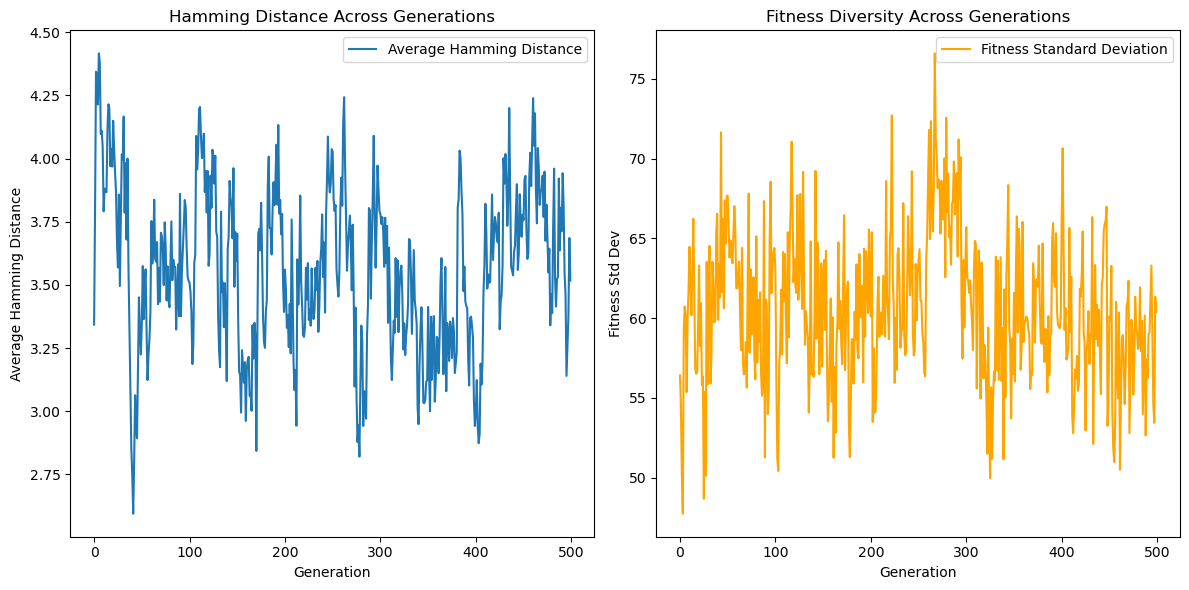

([[5, 9], [0], [2, 3, 8]], 291)

In [116]:
import matplotlib.pyplot as plt

def mkp_ga_with_diversity_tracking(items_df, knapsack_capacities, population_size=100, generations=500, mutation_rate=0.3, elitism_count=10):
    """
    Genetic Algorithm (GA) with Diversity Tracking for the Multiple Knapsack Problem (MKP).

    Parameters:
    - items_df (DataFrame): A pandas DataFrame containing columns 'item', 'value', and 'cost'.
    - knapsack_capacities (list): A list of capacities for each knapsack.
    - population_size (int): Number of individuals in the population.
    - generations (int): Number of generations for the GA.
    - mutation_rate (float): Probability of mutating a gene.
    - elitism_count (int): Number of best individuals to carry over directly to the next generation.

    Returns:
    - Tuple:
        - solution (list of lists): Indices of selected items for each knapsack.
        - best_value (int): The maximum value achieved.
    """
    num_items = len(items_df)
    num_knapsacks = len(knapsack_capacities)
    values = items_df['value'].tolist()
    costs = items_df['cost'].tolist()

    # Fitness function: Total value if constraints are satisfied, otherwise 0
    def fitness(solution):
        total_value = 0
        knapsack_loads = [0] * num_knapsacks  # Tracks total weight of items in each knapsack
        for i in range(num_items):
            knapsack_id = solution[i]
            if knapsack_id > 0:  # Item assigned to a knapsack
                knapsack_loads[knapsack_id - 1] += costs[i]
                if knapsack_loads[knapsack_id - 1] > knapsack_capacities[knapsack_id - 1]:
                    return 0  # Penalize infeasible solution
                total_value += values[i]
        return total_value

    # Probabilistic Initialization
    def initialize_population_probabilistic():
        average_capacity = sum(knapsack_capacities) / num_knapsacks
        average_cost = sum(costs) / num_items
        average_items_per_knapsack = average_capacity / average_cost

        population = []
        for _ in range(population_size):
            solution = [0] * num_items
            knapsack_loads = [0] * num_knapsacks
            for i in range(num_items):
                if random.random() < (average_items_per_knapsack / num_items):
                    # Assign item to a random knapsack if feasible
                    knapsack_choices = [
                        k + 1 for k in range(num_knapsacks)
                        if knapsack_loads[k] + costs[i] <= knapsack_capacities[k]
                    ]
                    if knapsack_choices:
                        chosen_knapsack = random.choice(knapsack_choices)
                        solution[i] = chosen_knapsack
                        knapsack_loads[chosen_knapsack - 1] += costs[i]
            population.append(solution)
        return population

    # Diversity tracking
    diversity_tracking = {"hamming_distance": [], "fitness_std_dev": []}

    def check_population_diversity(population, fitness_values):
        num_individuals = len(population)
        num_genes = len(population[0])
        
        # Genotypic Diversity: Hamming Distance
        hamming_distances = []
        for i in range(num_individuals):
            for j in range(i + 1, num_individuals):
                hamming_distances.append(
                    sum(1 for g1, g2 in zip(population[i], population[j]) if g1 != g2)
                )
        avg_hamming_distance = np.mean(hamming_distances) if hamming_distances else 0

        # Fitness Diversity: Standard Deviation of Fitness
        fitness_std_dev = np.std(fitness_values)

        return avg_hamming_distance, fitness_std_dev

    population = initialize_population_probabilistic()

    for generation in range(generations):
        # Evaluate fitness of the population
        fitness_values = [fitness(individual) for individual in population]
        total_fitness = sum(fitness_values)

        # Track diversity metrics
        hamming_distance, fitness_std_dev = check_population_diversity(population, fitness_values)
        diversity_tracking["hamming_distance"].append(hamming_distance)
        diversity_tracking["fitness_std_dev"].append(fitness_std_dev)

        if total_fitness > 0:  # Ensure we don't divide by zero
            probabilities = [f / total_fitness for f in fitness_values]
        else:
            probabilities = [1 / population_size] * population_size  # Uniform distribution if all solutions are invalid

        # Selection (roulette wheel)
        parents = random.choices(population, probabilities, k=population_size - elitism_count)

        # Crossover (uniform)
        next_generation = population[:elitism_count]  # Elitism: Keep top solutions
        for _ in range((population_size - elitism_count) // 2):
            parent1, parent2 = random.sample(parents, 2)
            child1 = [random.choice([parent1[i], parent2[i]]) for i in range(num_items)]
            child2 = [random.choice([parent1[i], parent2[i]]) for i in range(num_items)]
            next_generation.extend([child1, child2])

        # Mutation with repair
        for individual in next_generation[elitism_count:]:
            if random.random() < mutation_rate:
                mutation_point = random.randint(0, num_items - 1)
                mutation_knapsack = random.randint(1, num_knapsacks)
                individual[mutation_point] = mutation_knapsack

            # Repair infeasible solutions
            knapsack_loads = [0] * num_knapsacks
            for i in range(num_items):
                knapsack_id = individual[i]
                if knapsack_id > 0:
                    knapsack_loads[knapsack_id - 1] += costs[i]
                    if knapsack_loads[knapsack_id - 1] > knapsack_capacities[knapsack_id - 1]:
                        individual[i] = 0  # Remove item to ensure feasibility

        # Update population
        population = next_generation

    # Get the best solution
    best_solution = max(population, key=fitness)
    best_value = fitness(best_solution)

    # Format the solution as required: selected indices for each knapsack
    solution = [[] for _ in range(num_knapsacks)]
    for i in range(num_items):
        knapsack_id = best_solution[i]
        if knapsack_id > 0:
            solution[knapsack_id - 1].append(i)

    return solution, best_value, diversity_tracking


# Example usage
df = create_items_dataframe_integer(10, 10, 100, 5, 50)
knapsack_capacities = create_knapsack_capacities_integer(3, 50, 75)
solution, best_value, diversity_tracking = mkp_ga_with_diversity_tracking(df, knapsack_capacities)

# Plot diversity metrics
plt.figure(figsize=(12, 6))

# Plot Hamming Distance
plt.subplot(1, 2, 1)
plt.plot(diversity_tracking["hamming_distance"], label="Average Hamming Distance")
plt.title("Hamming Distance Across Generations")
plt.xlabel("Generation")
plt.ylabel("Average Hamming Distance")
plt.legend()

# Plot Fitness Standard Deviation
plt.subplot(1, 2, 2)
plt.plot(diversity_tracking["fitness_std_dev"], label="Fitness Standard Deviation", color="orange")
plt.title("Fitness Diversity Across Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness Std Dev")
plt.legend()

plt.tight_layout()
plt.show()

solution, best_value


In [120]:
def mkp_ga_with_repair(items_df, knapsack_capacities, population_size=100, generations=500, mutation_rate=0.3, elitism_count=10):
    """
    Genetic Algorithm (GA) with Repair Mechanism for the Multiple Knapsack Problem (MKP).

    Parameters:
    - items_df (DataFrame): A pandas DataFrame containing columns 'item', 'value', and 'cost'.
    - knapsack_capacities (list): A list of capacities for each knapsack.
    - population_size (int): Number of individuals in the population.
    - generations (int): Number of generations for the GA.
    - mutation_rate (float): Probability of mutating a gene.
    - elitism_count (int): Number of best individuals to carry over directly to the next generation.

    Returns:
    - Tuple:
        - solution (list of lists): Indices of selected items for each knapsack.
        - best_value (int): The maximum value achieved.
    """
    num_items = len(items_df)
    num_knapsacks = len(knapsack_capacities)
    values = items_df['value'].tolist()
    costs = items_df['cost'].tolist()

    # Fitness function: Total value if constraints are satisfied, otherwise 0
    def fitness(solution):
        total_value = 0
        knapsack_loads = [0] * num_knapsacks  # Tracks total weight of items in each knapsack
        for i in range(num_items):
            knapsack_id = solution[i]
            if knapsack_id > 0:  # Item assigned to a knapsack
                knapsack_loads[knapsack_id - 1] += costs[i]
                if knapsack_loads[knapsack_id - 1] > knapsack_capacities[knapsack_id - 1]:
                    return 0  # Penalize infeasible solution
                total_value += values[i]
        return total_value

    # Probabilistic Initialization
    def initialize_population_probabilistic():
        average_capacity = sum(knapsack_capacities) / num_knapsacks
        average_cost = sum(costs) / num_items
        average_items_per_knapsack = average_capacity / average_cost

        population = []
        for _ in range(population_size):
            solution = [0] * num_items
            knapsack_loads = [0] * num_knapsacks
            for i in range(num_items):
                if random.random() < (average_items_per_knapsack / num_items):
                    # Assign item to a random knapsack if feasible
                    knapsack_choices = [
                        k + 1 for k in range(num_knapsacks)
                        if knapsack_loads[k] + costs[i] <= knapsack_capacities[k]
                    ]
                    if knapsack_choices:
                        chosen_knapsack = random.choice(knapsack_choices)
                        solution[i] = chosen_knapsack
                        knapsack_loads[chosen_knapsack - 1] += costs[i]
            population.append(solution)
        return population

    # Repair Mechanism
    def repair_solution(solution):
        knapsack_loads = [0] * num_knapsacks
        for i, knapsack_id in enumerate(solution):
            if knapsack_id > 0:
                knapsack_loads[knapsack_id - 1] += costs[i]

        for knapsack_id in range(num_knapsacks):
            while knapsack_loads[knapsack_id] > knapsack_capacities[knapsack_id]:
                # Find items in the overfilled knapsack
                items_in_knapsack = [
                    i for i, k in enumerate(solution) if k == knapsack_id + 1
                ]
                # Remove the item with the lowest value-to-cost ratio
                worst_item = min(items_in_knapsack, key=lambda i: values[i] / costs[i])
                solution[worst_item] = 0
                knapsack_loads[knapsack_id] -= costs[worst_item]
        return solution

    population = initialize_population_probabilistic()

    for generation in range(generations):
        # Evaluate fitness of the population
        fitness_values = [fitness(individual) for individual in population]
        total_fitness = sum(fitness_values)

        if total_fitness > 0:  # Ensure we don't divide by zero
            probabilities = [f / total_fitness for f in fitness_values]
        else:
            probabilities = [1 / population_size] * population_size  # Uniform distribution if all solutions are invalid

        # Selection (roulette wheel)
        parents = random.choices(population, probabilities, k=population_size - elitism_count)

        # Crossover (uniform)
        next_generation = population[:elitism_count]  # Elitism: Keep top solutions
        for _ in range((population_size - elitism_count) // 2):
            parent1, parent2 = random.sample(parents, 2)
            child1 = [random.choice([parent1[i], parent2[i]]) for i in range(num_items)]
            child2 = [random.choice([parent1[i], parent2[i]]) for i in range(num_items)]
            next_generation.extend([child1, child2])

        # Mutation with repair
        for individual in next_generation[elitism_count:]:
            if random.random() < mutation_rate:
                mutation_point = random.randint(0, num_items - 1)
                mutation_knapsack = random.randint(1, num_knapsacks)
                individual[mutation_point] = mutation_knapsack

            # Repair the solution to ensure feasibility
            repair_solution(individual)

        # Update population
        population = next_generation

    # Get the best solution
    best_solution = max(population, key=fitness)
    best_value = fitness(best_solution)

    # Format the solution as required: selected indices for each knapsack
    solution = [[] for _ in range(num_knapsacks)]
    for i in range(num_items):
        knapsack_id = best_solution[i]
        if knapsack_id > 0:
            solution[knapsack_id - 1].append(i)

    return solution, best_value


# Example usage
df = create_items_dataframe_integer(10, 10, 100, 5, 50)
knapsack_capacities = create_knapsack_capacities_integer(3, 50, 75)
solution, best_value = mkp_ga_with_repair(df, knapsack_capacities)

solution, best_value


([[4, 5], [3, 6, 7, 8], [2]], 555)

In [121]:
from ortools.linear_solver import pywraplp

def multiple_knapsack(values, weights, capacities):
    """
    Solve the multiple knapsack problem using OR-Tools.

    Parameters:
    - values (List[int]): List of item values.
    - weights (List[int]): List of item weights.
    - capacities (List[int]): List of knapsack capacities.

    Returns:
    - List[List[int]]: The items assigned to each knapsack.
    - int: The maximum total value achieved.
    """
    num_items = len(values)
    num_knapsacks = len(capacities)

    # Initialize the solver
    solver = pywraplp.Solver.CreateSolver("SCIP")
    if not solver:
        return None, None

    # Decision variables: x[i][j] is 1 if item i is placed in knapsack j
    x = {}
    for i in range(num_items):
        for j in range(num_knapsacks):
            x[i, j] = solver.BoolVar(f"x_{i}_{j}")

    # Objective: Maximize total value
    solver.Maximize(solver.Sum(values[i] * x[i, j] for i in range(num_items) for j in range(num_knapsacks)))

    # Constraints: Each item can be placed in at most one knapsack
    for i in range(num_items):
        solver.Add(solver.Sum(x[i, j] for j in range(num_knapsacks)) <= 1)

    # Constraints: Knapsack capacities
    for j in range(num_knapsacks):
        solver.Add(solver.Sum(weights[i] * x[i, j] for i in range(num_items)) <= capacities[j])

    # Solve the problem
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        # Retrieve the solution
        knapsack_items = [[] for _ in range(num_knapsacks)]
        total_value = solver.Objective().Value()
        for i in range(num_items):
            for j in range(num_knapsacks):
                if x[i, j].solution_value() > 0:
                    knapsack_items[j].append(i)
        return knapsack_items, total_value
    else:
        return None, None


# Example usage
#values = [60, 100, 120, 80, 90, 10, 20, 30, 10, 20, 50, 20]
#weights = [10, 20, 30, 15, 25, 10, 40, 20, 50, 20, 40, 10]
#capacities = [50, 50, 50]  # Three knapsacks

values = df['value'].astype(int).tolist()
costs = df['cost'].astype(int).tolist()
capacities = knapsack_capacities

knapsack_solution, max_value = multiple_knapsack(values, costs, capacities)
print("Knapsack Solution:", knapsack_solution)
print("Maximum Value:", max_value)


Knapsack Solution: [[5, 7], [2, 3, 4], [1, 6, 8]]
Maximum Value: 616.0
